In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
import time

import matplotlib
import matplotlib.pyplot as plt
#plt.style.use("ggplot")

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial setup

In [2]:
# Location of US County shapefile used for creating the maps
shapefileFn = "simple-maps/examples/cb_2015_us_county_500k_clipped/cb_2015_us_county_500k_clipped.shp"
shapefileKey = "GEOID"

# Load data

### Migration data

In [3]:
countyList = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    countyList.append(line)
f.close()
county_to_idx = {county:idx for idx, county in enumerate(countyList)}
numberOfCounties = len(countyList)

In [4]:
county_to_name = {}
county_to_state = {}
f = open("data/co-est00int-tot.csv","r")
print(f.readline().strip())
for line in f:
    parts = line.strip().split(",")
    sumlev, region, division, state, county, stname, ctyname = parts[:7]
    county_fips = "%02d%03d" % (int(state), int(county))
    county_to_name[county_fips] = ctyname
    county_to_state[county_fips] = stname
f.close()

SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010


### Per county features

In [5]:
df_medium = pd.read_csv("data/affected_population_medium.csv")
df_high = pd.read_csv("data/affected_population_high.csv")

In [6]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

medium_total_pop = [
    df_medium["Total Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_affected_pop = [
    df_medium["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_unaffected_pop = [
    medium_total_pop[i] - medium_affected_pop[i]
    for i in range(len(medium_years))
]

high_total_pop = [
    df_high["Total Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_affected_pop = [
    df_high["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_unaffected_pop = [
    high_total_pop[i] - high_affected_pop[i]
    for i in range(len(high_years))
]

In [7]:
medium_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in medium_affected_pop
]

high_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in high_affected_pop
]

# DL Results

In [8]:
medium_baseline_migration = [np.load("output/dl_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/dl_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/dl_medium_ablation_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_flooded = [np.load("output/dl_medium_affected_results_flooded_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_unflooded = [np.load("output/dl_medium_affected_results_unflooded_%d.npy" % (year)) for year in medium_years]


high_baseline_migration = [np.load("output/dl_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/dl_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/dl_high_ablation_results_%d.npy" % (year)) for year in high_years]
high_affected_migration_flooded = [np.load("output/dl_high_affected_results_flooded_%d.npy" % (year)) for year in high_years]
high_affected_migration_unflooded = [np.load("output/dl_high_affected_results_unflooded_%d.npy" % (year)) for year in high_years]

model = "dl"

# ExtRad Results

In [17]:
medium_baseline_migration = [np.load("output/extrad_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/extrad_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/extrad_medium_ablation_results_%d.npy" % (year)) for year in medium_years]

high_baseline_migration = [np.load("output/extrad_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/extrad_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/extrad_high_ablation_results_%d.npy" % (year)) for year in high_years]

model = "extrad"

# High

In [9]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    count = 0
    for j, county in enumerate(countyList):
        if t_affected_incoming[j] - t_baseline_incoming[j] > 0:
            count += 1
            
    print(year, count / float(len(countyList)))

(2042, 0.8766902768834514)
(2059, 0.8396651641983258)
(2071, 0.8486799742433999)
(2082, 0.8721828718609144)
(2091, 0.9256278171281391)
(2100, 0.9993560849967804)


In [31]:
i, year = 5, 2100
t_affected_incoming =  high_affected_migration_flooded[i].sum(axis=0)
t_affected_outgoing =  high_affected_migration_flooded[i].sum(axis=1)
t_baseline_incoming =  high_affected_migration_flooded[i].sum(axis=0)
t_mapping = {}
f = open("results/results_high.csv","w")
f.write("County FIPS,County Name,County State,Incoming,Outgoing,Incoming-Outgoing\n")
for j, county in enumerate(countyList):
    f.write("%s,%s,%s,%f,%f,%f\n" % (
        county, county_to_name[county], county_to_state[county],
        t_affected_incoming[j], t_affected_outgoing[j], t_affected_incoming[j]-t_affected_outgoing[j]
        )
    )
    
    t_names = county_to_name[county].split(" ")
    if t_names[-1].lower() != "city":
        t_name = " ".join(t_names[:-1])
    else:
        t_name = " ".join(t_names)
    t_mapping["%s, %s" % (t_name.lower(), county_to_state[county].lower())] = j
    
f.close()

In [54]:
f = open("results/nclimate3271-s2_county.csv","r")
header_line = f.readline().strip().split(",")
print(header_line)
fixit = {
    "prince georges": "Prince George's",
    "du page": "dupage",
    "dona ana": "Do\F1a Ana", 
    #"desoto": "de soto",
    "radford": "radford city",
    "la salle": "lasalle",
    "la porte": "laporte",
    "st marys": "st. mary's",
    "queen annes": "queen anne's"
}
hauer_incoming = defaultdict(int)
for line in f:
    parts = line.strip().split(",")
    incoming = 0 if parts[2].strip() == "-" else int(parts[2])
    #print(parts)
    
    if parts[0].lower() in fixit:
        parts[0] = fixit[parts[0].lower()]
    else:
    
        if parts[0].lower().startswith("de "):
            parts[0] = parts[0].replace("De ", "De")
        elif parts[0].lower().startswith("st "):
            parts[0] = parts[0].replace("St ", "St. ")
    
    if parts[0].lower() == "lasalle" and parts[1].lower() == "texas":
        parts[0] = "la salle"
    if parts[0].lower() == "desoto" and parts[1].lower() == "louisiana":
        parts[0] = "de soto"
    
    t_name = "%s, %s" % (parts[0].lower(), parts[1].lower())
        
    if t_name in t_mapping:
        hauer_incoming[t_mapping[t_name]] = incoming

['County', 'State', ' In-Migration ', ' Out-Migration ', ' Net Migration ', ' +/- ', ' Rank']


In [47]:
len(t_counties)

1725

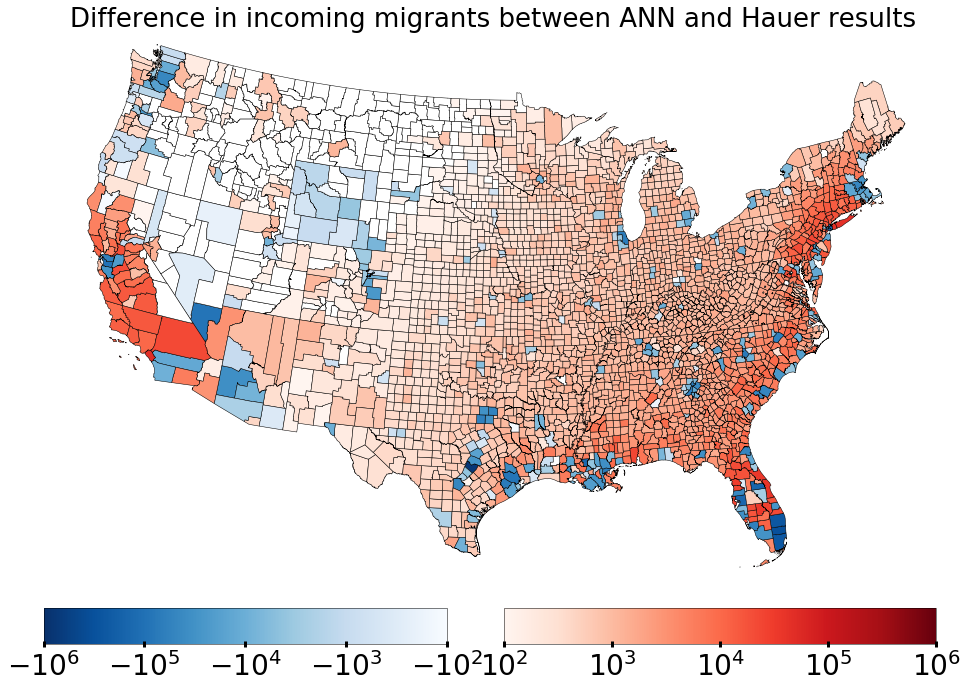

In [62]:
dl_incoming =  high_affected_migration_flooded[-1].sum(axis=0)

map_data = {
    county: dl_incoming[j] - hauer_incoming[j]
    for j, county in enumerate(countyList)
}
map_data["46102"] = 0

differenceMap(
    shapefileFn,
    shapefileKey,
    map_data,
    #outputFn="figures/%s_difference_both_high_%d.png" % (model, year),
    #noDataColor="#0000FFFF",
    #cmap="Reds",
    bounds=[22, 49, -119, -64],
    title="Difference in incoming migrants between ANN and Hauer results",
    colorbarRange=(1e2, 1e6),
    logScale=True,
)